<a href="https://colab.research.google.com/github/HoYoungChun/financial_data_analysis/blob/main/Fixed_rate_investment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fixed_rate_investment(정률투자법)

### Basic Setting

#### Load modules

In [1]:
import pandas as pd
import requests
from tqdm import tqdm

### Get Daily Prices

#### KODEX 200(Daily)

In [ ]:
kodex_200 = pd.DataFrame()

kodex_url = 'https://finance.naver.com/item/sise_day.nhn?code=069500'

for page in tqdm(range(1,100)):
    pg_url = '{url}&page={page}'.format(url=kodex_url, page=page)
    pg_url = requests.get(pg_url, headers={'User-agent':'Mozilla/5.0'}).text
    kodex_200 = kodex_200.append(pd.read_html(pg_url)[0], ignore_index=True)
    #pd.read_html(pg_url)[0]
kodex_200

In [3]:
kodex_200 = kodex_200.dropna()
kodex_200.columns = ['date','close','over_the_day','open','high','low','volume']
kodex_200.date = pd.to_datetime(kodex_200.date)

print('출처: ', kodex_url)
print(kodex_200.shape)
kodex_200.head()

출처:  https://finance.naver.com//item/sise_day.nhn?code=069500
(990, 7)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,date,close,over_the_day,open,high,low,volume
1,2021-07-13,43460.0,275.0,43380.0,43515.0,43380.0,271018.0
2,2021-07-12,43185.0,385.0,43060.0,43260.0,43060.0,3929269.0
3,2021-07-09,42800.0,460.0,42840.0,43050.0,42445.0,8288519.0
4,2021-07-08,43260.0,455.0,43765.0,43875.0,43260.0,5209381.0
5,2021-07-07,43715.0,275.0,43840.0,43840.0,43605.0,3816728.0


#### Gov 3-year(Daily)

In [5]:
gov_3 = pd.DataFrame()
gov_url = 'https://finance.naver.com/item/sise_day.nhn?code=114260'

for page in tqdm(range(1,100)):
    pg_url = '{url}&page={page}'.format(url=gov_url, page=page)
    pg_url = requests.get(pg_url, headers={'User-agent':'Mozilla/5.0'}).text
    gov_3 = gov_3.append(pd.read_html(pg_url)[0],ignore_index=True)

100%|██████████| 99/99 [00:52<00:00,  1.87it/s]


In [ ]:
gov_3

In [ ]:
gov_3 = gov_3.dropna()
gov_3.columns = ['date','close','over_the_day','open','high','low','volume']
gov_3.date = pd.to_datetime(gov_3.date)
gov_3

### Turn into Monthly DataFrame

In [12]:
kodex_monthly = pd.DataFrame()
gov_monthly = pd.DataFrame()

In [ ]:
kodex_200['date'].dt.year #연
kodex_200['date'].dt.month #월
kodex_200['date'].dt.day #일
kodex_200['date'].dt.dayofweek #요일
kodex_200['date'].dt.day_name() #요일

In [14]:
for y in range(2017,2022):
    for m in range(1,13):
        kodex_monthly = kodex_monthly.append(kodex_200[(kodex_200['date'].dt.year == y) & (kodex_200['date'].dt.month==m)].head(1))
        gov_monthly = gov_monthly.append(gov_3[(gov_3.date.dt.year==y) & (gov_3.date.dt.month==m)].head(1))



In [15]:
# list comprehension
kodex_monthly.index = [x for x in range(len(kodex_monthly))]
gov_monthly.index = [x for x in range(len(gov_monthly))]

### Backtesting

In [16]:
def backtest(beginning_asset = 100000):
    kodex_pct = 0.5
    gov_pct = 1 - kodex_pct
    asset =[beginning_asset] #방법1

    for i in range(len(kodex_monthly)-1):
        #KOSPI
        kodex_shares = (beginning_asset * kodex_pct) / kodex_monthly.iloc[i].close #t 시점
        kodex_ending_value = kodex_shares * kodex_monthly.iloc[i+1].close #t+1 시점
    
        #Gov 3-year
        gov_shares = (beginning_asset * gov_pct) / gov_monthly.iloc[i].close #t 시점
        gov_ending_value = gov_shares * gov_monthly.iloc[i+1].close #t+1 시점

        #rebalancing
        total_ending_value = kodex_ending_value + gov_ending_value

        asset.append(total_ending_value)

        beginning_asset = total_ending_value
    
    #방법2 asset.insert(0, 100000)

    return asset

In [ ]:
result = backtest(100000)
result

In [22]:
back_test = {
    'date':kodex_monthly['date'],
    'backtest':result,
    'KODEX_200' : (kodex_monthly['close'] / kodex_monthly.iloc[0].close)*100000, #코스피 벤치마크
    'GOV_3Y' : (gov_monthly['close'] / gov_monthly.iloc[0].close)*100000, #국고채3년물 벤치마크
}

In [ ]:
back_test = pd.DataFrame(back_test)
back_test

### Visualization

In [25]:
# magic code
%matplotlib inline
import matplotlib.pyplot as plt

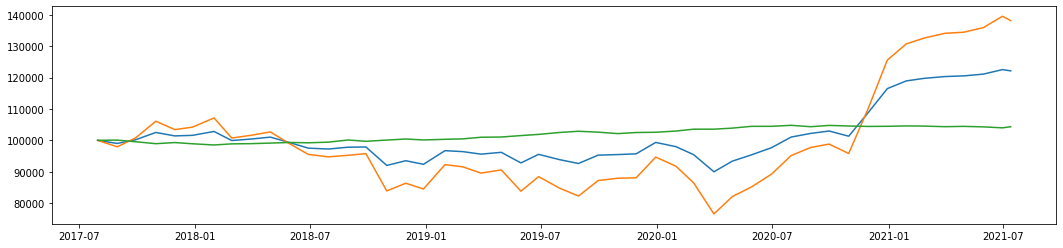

In [35]:
plt.figure(figsize=(18,4)) #빈 캔버스 만들기
plt.plot(back_test.date,back_test.backtest)
plt.plot(back_test.date,back_test.KODEX_200)
plt.plot(back_test.date,back_test.GOV_3Y)

plt.show()